In [15]:
import numpy as np
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
import jax.numpy as jnp
from omega_gw_jax import OmegaGWjax
# Set matplotlib parameters
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
from nautilus import Sampler
import time
from scipy.special import logsumexp

# Set matplotlib parameters
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)

Running inference with number of nodes: 5, free nodes: 3


<ErrorbarContainer object of 3 artists>

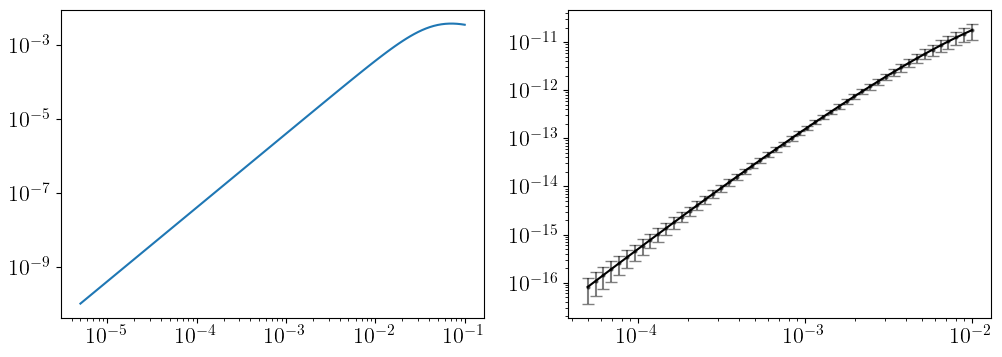

In [16]:
# Load the gravitational wave background data.
model = 'IR'
data = np.load(f'../bpl_{model}_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']
p_arr = data['p_arr']
pz_amp = data['pz_amp']

# Set up internal momenta for the OmegaGWjax calculator.
s = jnp.linspace(0, 1, 15)  # rescaled internal momentum
t = jnp.logspace(-5, 5, 200)  # rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

# Create the gravitational wave background calculator.
gwb_calculator = OmegaGWjax(s=s, t=t, f=frequencies, norm="RD", jit=True)

num_nodes = 5
print(f"Running inference with number of nodes: {num_nodes}, free nodes: {num_nodes - 2}")
free_nodes = num_nodes - 2

# Set the range for the x (log10) nodes using the data.
pk_min, pk_max = min(p_arr), max(p_arr)
left_node = np.log10(pk_min)
right_node = np.log10(pk_max)

# Set the y range for the interpolation.
y_max = -1.
y_min = -10.
y_mins = np.array(num_nodes * [y_min])
y_maxs = np.array(num_nodes * [y_max])

def split_vmap(func,input_arrays,batch_size=8):
    """
    Utility to split vmap over a function taking multiple arrays as input into multiple chunks, useful for reducing memory usage.
    """
    num_inputs = input_arrays[0].shape[0]
    num_batches = (num_inputs + batch_size - 1 ) // batch_size
    batch_idxs = [jnp.arange( i*batch_size, min( (i+1)*batch_size,num_inputs  )) for i in range(num_batches)]
    res = [vmap(func)(*tuple([arr[idx] for arr in input_arrays])) for idx in batch_idxs]
    nres = len(res[0])
    # now combine results across batches and function outputs to return a tuple (num_outputs, num_inputs, ...)
    results = tuple( jnp.concatenate([x[i] for x in res]) for i in range(nres))
    return results

@jit
def prior(cube):
    """
    Transforms the input cube from [0,1] uniform parameters to the desired prior space.
    This vectorized version supports cube being either a 1D array of shape (nd,)
    or a 2D array of shape (Npoints, nd).
    """
    cube = jnp.atleast_2d(cube.copy())
    N = free_nodes  # Number of x parameters
    x = cube[:, :N]
    exponents = 1.0 / jnp.arange(1, N + 1)
    y_vals = x ** exponents  # shape (Npoints, free_nodes)
    t_arr = jnp.cumprod(y_vals[:, ::-1], axis=1)[:, ::-1]
    xs = t_arr * (right_node - left_node) + left_node
    ys = cube[:, N:]
    ys = ys * (y_maxs[None, :] - y_mins[None, :]) + y_mins[None, :]
    return jnp.concatenate([xs, ys], axis=1)

def interpolate(nodes, vals, x):
    # Create a cubic spline interpolation of log10(Pζ) and then convert back to linear scale.
    # spl = CubicSpline(nodes, vals, check=False)
    # Testing linear interpolation
    # spl = lambda x: 
    res = jnp.power(10, jnp.interp(x, nodes, vals))
    res = jnp.where(x < left_node, 0, res)
    res = jnp.where(x > right_node, 0, res)
    return res

def get_gwb(nodes, vals):
    # Given nodes and values, create a function for Pζ and compute Ω_GW.
    pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
    omegagw = gwb_calculator(pf, frequencies)
    return (omegagw,)

# JIT compile get_gwb for speed.
get_gwb_func = jit(get_gwb)

@jit
def likelihood(params):
    params = jnp.atleast_2d(params)
    nodes = params[:, :free_nodes]
    # Pad nodes with fixed endpoints
    nodes = jnp.pad(nodes, ((0, 0), (1, 1)), 'constant',
                      constant_values=((0, 0), (left_node, right_node)))
    vals = params[:, free_nodes:]
    omegagw = split_vmap(get_gwb_func, (nodes, vals), batch_size=200)[0]
    diff = omegagw - Omegas
    sol =jnp.linalg.solve(cov, diff.T).T
    res = -0.5 * jnp.sum(diff * sol, axis=1)
    res = jnp.where(jnp.isnan(res), -1e10, res)
    res = jnp.where(res < -1e10, -1e10, res)
    return res, omegagw

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.loglog(p_arr,pz_amp)
ax2.loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)


In [17]:
ndim = free_nodes + num_nodes
sampler = Sampler(prior, likelihood, ndim, pass_dict=False, vectorized=True,resume=True
                                            ,pool=(None,4),filepath=f'./nautilus_bpl_{model}_{num_nodes}_linear_nodes.h5') 

start = time.time()
sampler.run(verbose=True, f_live=0.001, n_like_max=int(1.5e5))#, n_eff=2000*ndim)
end = time.time()
print('Time taken: {:.2f} s'.format(end - start))
print('log Z: {:.2f}'.format(sampler.log_z))

    # Retrieve posterior samples.
samples, logl, logwt, omegaGW_blob = sampler.posterior(return_blobs=True)
np.savez(f'nautilus_bpl_{model}_{num_nodes}_linear_nodes.npz', samples=samples, logl=logl, logwt=logwt, logz=sampler.log_z)


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 24     | 5        | 4        | 139000   | N/A    | 10010 | -11.39   
Time taken: 0.00 s
log Z: -11.39


In [18]:
print(f"shapes: samples {samples.shape}, OmegaGW {omegaGW_blob.shape}")

shapes: samples (139000, 8), OmegaGW (139000, 50)


In [19]:
# plot functional posterior

def weighted_median(data, weights):
    """
    Compute the weighted median of data.
    """
    # Sort the data and weights.
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    # Compute the cumulative sum of the weights.
    cdf = np.cumsum(s_weights)
    # Find the median value.
    idx = np.searchsorted(cdf, 0.5)
    return s_data[idx]

def plot_functional_posterior(vals=[], k_arr=[], intervals=[99.7, 95., 68.],
                              weights = None,
                              ylabels=[r'$P_{\zeta}$', r'$\Omega_{\rm GW}$'],
                              aspect_ratio=(6, 5),
                              interval_cols=[('#006FED', 0.2), ('#006FED', 0.4), ('#006FED', 0.6)]):
    """
    Plot the posterior of y = f(k|x) using symmetric credible intervals.
    """
    nfuncs = len(vals)
    fig, ax = plt.subplots(1, nfuncs, figsize=(aspect_ratio[0] * nfuncs, aspect_ratio[1]), constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    if weights is None:
        weights = np.ones(vals.shape[0])
    for i, val in enumerate(vals):
        # weights_i = weights[i]
        # print(weights_i.shape)
        print(val.shape)
        for j, interval in enumerate(intervals):
            y_low, y_high = np.percentile(val, [50 - interval / 2, 50 + interval / 2], axis=0
                                          ,weights=weights,method='inverted_cdf')
            ax[i].fill_between(k_arr[i], y_low, y_high, color=interval_cols[j][0], alpha=interval_cols[j][1])
        # medians = np.apply_along_axis(weighted_median, 0, val, weights)
        # ax[i].plot(k_arr[i], medians, color='#006FED', lw=2.5)
        # ax[i].plot(k_arr[i], np.median(val, axis=0), color='#006FED', lw=2.5)
        ax[i].set_ylabel(ylabels[i])
    return fig, ax

(5149, 200)
(5149, 50)


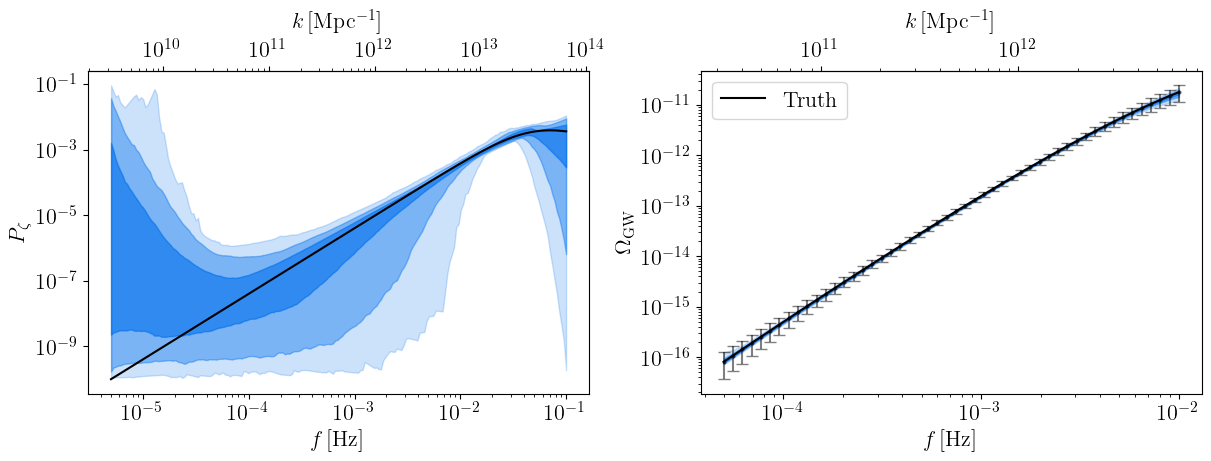

In [20]:
num_samples = 5000
thinning = max(1,len(samples)//num_samples)
xs = samples[:, :free_nodes][::thinning]
ys = samples[:, free_nodes:][::thinning]
xs = jnp.pad(xs, ((0, 0), (1, 1)), 'constant', constant_values=((0, 0), (left_node, right_node)))
ys = jnp.array(ys)
gwb_amps = omegaGW_blob[::thinning]
p_arr_local = jnp.logspace(left_node+0.001, right_node-0.001, 200)
logwt_total = logsumexp(logwt)
weights = np.exp(logwt - logwt_total)
weights = weights / weights.sum()
thinned_weights = weights[::thinning]

def get_pz(nodes, vals):
    # Given nodes and vals, compute Pζ and Ω_GW.
    pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
    pz_amps = pf(p_arr_local)
    return (pz_amps,)

pz_amps = split_vmap(get_pz, (xs, ys), batch_size=100)[0]

fig, ax = plot_functional_posterior([pz_amps, gwb_amps],
                                    k_arr=[p_arr_local, frequencies],
                                    weights = thinned_weights,
                                    aspect_ratio=(6,4.5))
ax[0].loglog(p_arr, pz_amp, color='k', lw=1.5)
ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
ax[1].legend()
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
plt.savefig(f'./nautilus_bpl_{model}_{num_nodes}_linear_nodes_posterior.pdf',bbox_inches='tight')

Running inference with number of nodes: 5, free nodes: 3


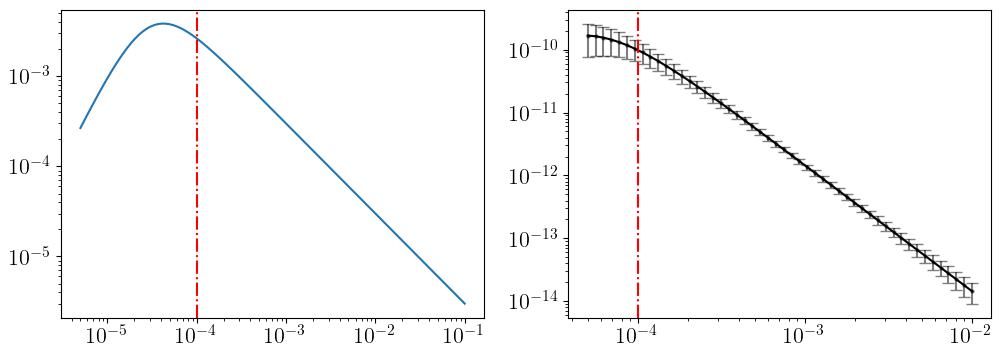

In [21]:
# Load the gravitational wave background data.
model = 'UV'
data = np.load(f'../bpl_{model}_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']
p_arr = data['p_arr']
pz_amp = data['pz_amp']

# Set up internal momenta for the OmegaGWjax calculator.
s = jnp.linspace(0, 1, 15)  # rescaled internal momentum
t = jnp.logspace(-5, 5, 200)  # rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

# Create the gravitational wave background calculator.
gwb_calculator = OmegaGWjax(s=s, t=t, f=frequencies, norm="RD", jit=True)

num_nodes = 5
print(f"Running inference with number of nodes: {num_nodes}, free nodes: {num_nodes - 2}")
free_nodes = num_nodes - 2

# Set the range for the x (log10) nodes using the data.
pk_min, pk_max = min(p_arr), max(p_arr)
left_node = np.log10(pk_min)
right_node = np.log10(pk_max)

# Set the y range for the interpolation.
y_max = -1.
y_min = -10.
y_mins = np.array(num_nodes * [y_min])
y_maxs = np.array(num_nodes * [y_max])

@jit
def likelihood(params):
    params = jnp.atleast_2d(params)
    nodes = params[:, :free_nodes]
    # Pad nodes with fixed endpoints
    nodes = jnp.pad(nodes, ((0, 0), (1, 1)), 'constant',
                      constant_values=((0, 0), (left_node, right_node)))
    vals = params[:, free_nodes:]
    omegagw = split_vmap(get_gwb_func, (nodes, vals), batch_size=200)[0]
    diff = omegagw - Omegas
    sol =jnp.linalg.solve(cov, diff.T).T
    res = -0.5 * jnp.sum(diff * sol, axis=1)
    res = jnp.where(jnp.isnan(res), -1e10, res)
    res = jnp.where(res < -1e10, -1e10, res)
    return res, omegagw

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.loglog(p_arr,pz_amp)
ax2.loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')

ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
for ax in [ax1,ax2]:
    ax.axvline(1e-4,color='r',ls='-.')

In [22]:
ndim = free_nodes + num_nodes
sampler = Sampler(prior, likelihood, ndim, pass_dict=False, vectorized=True,resume=True
                                            ,pool=(None,4),filepath=f'./nautilus_bpl_{model}_{num_nodes}_linear_nodes.h5') 

start = time.time()
sampler.run(verbose=True, f_live=0.001, n_like_max=int(4e5))#, n_eff=2000*ndim)
end = time.time()
print('Time taken: {:.2f} s'.format(end - start))
print('log Z: {:.2f}'.format(sampler.log_z))

    # Retrieve posterior samples.
samples, logl, logwt, omegaGW_blob = sampler.posterior(return_blobs=True)
np.savez(f'nautilus_bpl_{model}_{num_nodes}_linear_nodes.npz', samples=samples, logl=logl, logwt=logwt, logz=sampler.log_z)


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Stopped   | 33     | 5        | 8        | 400000   | N/A    | 2804  | -17.29   
Time taken: 0.00 s
log Z: -17.29


(5000, 200)
(5000, 50)


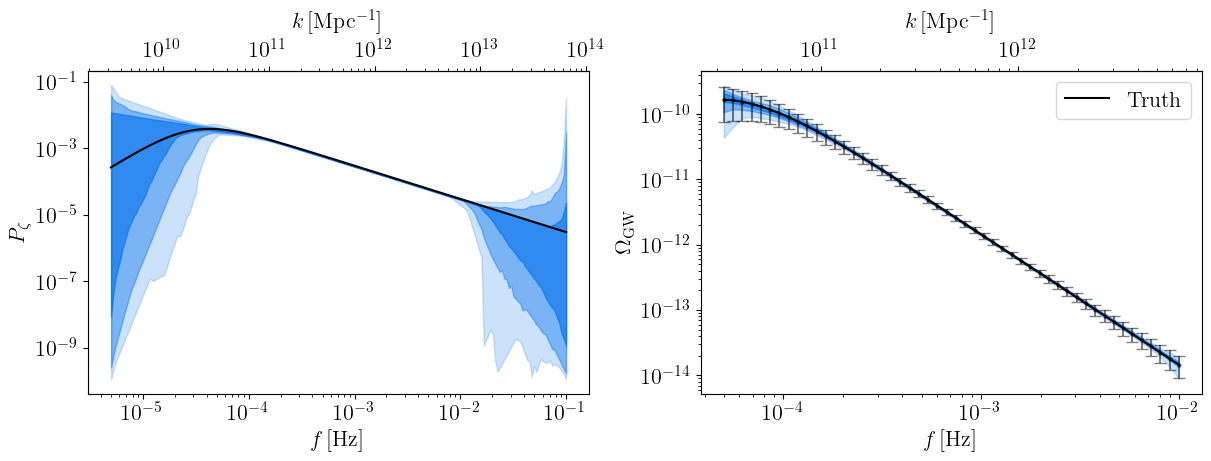

In [23]:
num_samples = 5000
thinning = max(1,len(samples)//num_samples)
xs = samples[:, :free_nodes][::thinning]
ys = samples[:, free_nodes:][::thinning]
xs = jnp.pad(xs, ((0, 0), (1, 1)), 'constant', constant_values=((0, 0), (left_node, right_node)))
ys = jnp.array(ys)
gwb_amps = omegaGW_blob[::thinning]
p_arr_local = jnp.logspace(left_node+0.001, right_node-0.001, 200)
logwt_total = logsumexp(logwt)
weights = np.exp(logwt - logwt_total)
weights = weights / weights.sum()
thinned_weights = weights[::thinning]

def get_pz(nodes, vals):
    # Given nodes and vals, compute Pζ and Ω_GW.
    pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
    pz_amps = pf(p_arr_local)
    return (pz_amps,)

pz_amps = split_vmap(get_pz, (xs, ys), batch_size=100)[0]

fig, ax = plot_functional_posterior([pz_amps, gwb_amps],
                                    k_arr=[p_arr_local, frequencies],
                                    weights = thinned_weights,
                                    aspect_ratio=(6,4.5))
ax[0].loglog(p_arr, pz_amp, color='k', lw=1.5)
ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
ax[1].legend()
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
plt.savefig(f'./nautilus_bpl_{model}_{num_nodes}_linear_nodes_posterior.pdf',bbox_inches='tight')

In [24]:
# from dynesty import DynamicNestedSampler

# # JIT compile get_gwb for speed.

# def get_gwb(nodes, vals):
#     # Given nodes and values, create a function for Pζ and compute Ω_GW.
#     pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
#     omegagw = gwb_calculator(pf, frequencies)
#     return omegagw

# # JIT compile get_gwb for speed.
# get_gwb_func = jit(get_gwb)

# @jit
# def likelihood(params):
#     nodes = params[:free_nodes]
#     # Pad nodes with fixed endpoints
#     nodes = jnp.pad(nodes, ((1, 1),), 'constant', constant_values=(left_node, right_node))
#     vals = params[free_nodes:]
#     # print(f"shapes: {nodes.shape}, {vals.shape}")
#     omegagw = get_gwb_func(nodes,vals) #split_vmap(get_gwb_func, (nodes, vals), batch_size=100)[0]
#     diff = omegagw - Omegas
#     # print(f"diff shape: {diff.shape}")
#     sol = jnp.linalg.solve(cov, diff.T).T
#     # print(f"sol shape: {sol.shape}")
#     res = -0.5 * jnp.dot(diff, sol.T)
#     res = jnp.where(jnp.isnan(res), -1e10, res)
#     res = jnp.where(res < -1e10, -1e10, res)
#     return res, omegagw

# def prior_1D(cube):
#     # Order and transform nodes to be in the correct range, from Polychord SortedUniformPrior
#     params = cube.copy()
#     x = params[:free_nodes]
#     N = free_nodes
#     t_arr = np.zeros(N)
#     t_arr[N - 1] = x[N - 1] ** (1.0 / N)
#     for n in range(N - 2, -1, -1):
#         t_arr[n] = x[n] ** (1.0 / (n + 1)) * t_arr[n + 1]
#     xs = t_arr * (right_node - left_node) + left_node
#     ys = params[free_nodes:]
#     ys = ys * (y_max - y_min) + y_min
#     return jnp.concatenate([xs, ys])

# ndim = free_nodes + num_nodes
# sampler = DynamicNestedSampler(likelihood, prior_1D, ndim,sample='rwalk',blob=True,)
#     # sampler = Sampler(prior, likelihood, ndim, pass_dict=False, vectorized=True
#     #                                         ,pool=(None,4),filepath=f'./nautilus_{model}_{num_nodes}_linear_nodes.h5') 

# start = time.time()
# sampler.run_nested(print_progress=True,dlogz_init=0.01,maxcall=int(2e5),resume=False)#, n_eff=2000*ndim)
# end = time.time()
# res = sampler.results
# logz = res['logz'][-1]
# logzerr = res['logzerr'][-1]
# print('log Z: {:.2f} +/- {:.2f}'.format(logz, logzerr))
# print('Time taken: {:.2f} s'.format(end - start))
# samples = res.samples_equal()
# weights = np.ones(samples.shape[0])
# gwb_amps = res['blob']

In [25]:
# num_samples = 2500
# thinning = max(1,len(samples)//num_samples)
# xs = samples[:, :free_nodes][::thinning]
# ys = samples[:, free_nodes:][::thinning]
# xs = jnp.pad(xs, ((0, 0), (1, 1)), 'constant', constant_values=((0, 0), (left_node, right_node)))
# ys = jnp.array(ys)
# # gwb_amps = omegaGW_blob[::thinning]
# p_arr_local = jnp.logspace(left_node+0.001, right_node-0.001, 200)
# # logwt_total = logsumexp(logwt)
# # weights = np.exp(logwt - logwt_total)
# # weights = weights / weights.sum()
# thinned_weights = np.ones(len(xs)) #weights[::thinning]
# print(f"shapes: {xs.shape}, {ys.shape}, {thinned_weights.shape}")

# def get_pz_omega(nodes, vals):
#     # Given nodes and vals, compute Pζ and Ω_GW.
#     pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
#     pz_amps = pf(p_arr_local)
#     omegagw = get_gwb_func(nodes,vals)
#     return pz_amps,omegagw

# pz_amps, gwb_amps = split_vmap(get_pz_omega, (xs, ys), batch_size=100)

# fig, ax = plot_functional_posterior([pz_amps, gwb_amps],
#                                     k_arr=[p_arr_local, frequencies],
#                                     weights = thinned_weights,
#                                     aspect_ratio=(6,4.5))
# ax[0].loglog(p_arr, pz_amp, color='k', lw=1.5)
# ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
# ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
# ax[1].legend()
# k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
# for x in ax:
#     x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
#     secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
#     secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 